In [1]:
%set_env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [118]:

import numpy as np
import pandas as pd
import os
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from alibi.explainers.similarity.grad import GradientSimilarity

In [120]:
def to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return np.eye(num_classes, dtype='uint8')[y].astype('float32')

class TorchDataset(torch.utils.data.Dataset):
    """Utility class to create a torch dataloader from numpy arrays.
    """
    def __init__(self, *indexables):
        self.indexables = indexables

    def __getitem__(self, idx):
        output = tuple(indexable[idx] for indexable in self.indexables)
        return output if len(output) > 1 else output[0]

    def __len__(self):
        return len(self.indexables[0])

## Load data

Loading and preparing the 20 news group data set.

In [112]:
data = fetch_20newsgroups(shuffle=True, random_state=1, subset='all',
                          remove=('headers', 'footers', 'quotes'),
                          return_X_y=False)
X, y = np.asarray(data.data), data.target
target_names = data.target_names

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
y_train, y_test = to_categorical(y_train, num_classes=20), to_categorical(y_test, num_classes=20)

## Define and train model

We define and train a pytorch classifier using sentence embeddings as inputs

In [113]:
load_20ng_model = False
save_model = False

### Define model

In [115]:
class EmbeddingModel:
    def __init__(
        self,
        model_name: str = 'paraphrase-MiniLM-L6-v2',  # https://www.sbert.net/docs/pretrained_models.html
        max_seq_length: int = 200,
        batch_size: int = 32,
        device: torch.device = None
    ) -> None:
        if not isinstance(device, torch.device):
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.encode_text = SentenceTransformer(model_name).to(device)
        self.encode_text.max_seq_length = max_seq_length
        self.batch_size = batch_size
    
    def __call__(self, x: np.ndarray) -> np.ndarray:
        return self.encode_text.encode(x, 
                                       convert_to_numpy=True, 
                                       batch_size=self.batch_size,
                                       show_progress_bar=False)

    
class Classifier(nn.Module):
    def __init__(
        self, 
        n_classes= 20
    ) -> None:
        """ Text classification model from sentence embeddings. """
        super().__init__()
        self.head = nn.Sequential(nn.Linear(384, 256), 
                                  nn.LeakyReLU(.1), 
                                  nn.Dropout(.5), 
                                  nn.Linear(256, n_classes))
        
    def forward(self, sentence_embeddings) -> torch.Tensor:
        return self.head(sentence_embeddings)



### Train model

In [117]:
epochs = 3

filepath = './model_20ng/'  # change to directory where model is saved

if load_20ng_model:
    pass

else:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # get embeddings
    print('Getting train embeddings')
    embedding_model = EmbeddingModel(device=device)
    train_embeddings = torch.Tensor(embedding_model(X_train)).to(device)
    y_train = torch.Tensor(y_train).to(device)
    
    # initialize dataloader and classifier
    train_loader = DataLoader(TorchDataset(train_embeddings, y_train), batch_size=32, shuffle=True)
    model = Classifier().to(device)
    
    print('training classifier')
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    for epoch in range(epochs):
        for x, y in tqdm(train_loader):
            y_hat = model(x)
            optimizer.zero_grad()
            loss = loss_fn(y_hat, y)
            loss.backward()
            optimizer.step()

    if save_model:
        pass

Getting train embeddings
training classifier


100%|███████████████| 472/472 [00:00<00:00, 1143.50it/s]


## Find similaraties 

Initializing a `GradientSimilarity` explainer instance

Selecting a reference set of 1000 random samples from the training set. The `GradientSimilarity` explainer will find the most similar instances among those. This downsampling step is performed in order to speed up the `fit` step.

In [152]:
idxs_ref = np.random.choice(len(X_train), 1000, replace=False)
X_ref = X_train[idxs_ref] 
ref_embeddings = train_embeddings.detach().cpu().numpy()[idxs_ref] 
y_ref = y_train.detach().cpu().numpy()[idxs_ref]

In [156]:
gsm = GradientSimilarity(model, 
                         loss_fn, 
                         precompute_grads=True, 
                         sim_fn='grad_cos', 
                         backend='pytorch', 
                         device=device)

In [157]:
y_ref

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

Fitting the explainer on the reference data

In [158]:
gsm.fit(ref_embeddings, y_ref)

GradientSimilarity(meta={
  'name': 'GradientSimilarity',
  'type': ['whitebox'],
  'explanations': ['local'],
  'params': {
              'sim_fn_name': 'grad_cos',
              'store_grads': True,
              'backend_name': 'pytorch',
              'task_name': 'classification'}
            ,
  'version': '0.6.6dev'}
)

Selecting 5 random instances from the test set

In [159]:
sample_embedding = embedding_model(X_test[:1])

In [160]:
y_sample = y_test[:1]
y_sample.shape

(1, 20)

In [165]:
explanation = gsm.explain(sample_embedding, y_sample)

In [169]:
X_test[0]

'...\n\nI seriously doubt that any practical implementation of this proposal would\nplace the onus on the individual to register keys.  Realistically, the\nClipper-Chip will probably emit an ID code which will serve as the identifier\nwhen requesting the key fragments.  The chip manufacturer would register\nthis identifier code vs. key combination when the chip is made and the\n(uninitiated) end-user can therefore remain completely outside the loop.\nThe chip could be used in a cellular phone, a modem, or other device --\nit really makes no difference:  When the authorities detect the use of this\nencryption standard during surveillance, they would then capture the ID\nand apply for the key in order to decrypt the data.'

In [174]:
target_names[y_test[0].argmax()]

'sci.crypt'

In [177]:
sim_nb = 1

In [178]:
X_ref[explanation.data['ordered_indices'][sim_nb]]

"Maybe I don't know enough to know what I am asking, but with millions\nof these things about, how could the algorythm possibly stay secret?\nCouldn't some clever hackers just grind the thing down layer by layer,\nand see how it worked?\n\n-- "

In [175]:
target_names[y_ref[explanation.data['ordered_indices'][0]].argmax()]

'sci.crypt'

In [11]:
idxs_samples = np.random.choice(len(X_test), 5, replace=False)
X_sample, y_sample = X_test[idxs_samples], y_test[idxs_samples]
preds = model(X_sample).numpy().argmax(axis=1)

Getting the most similar instance for the each of the 5 test samples

In [12]:
ds = []
for j in range(len(X_sample)):
    expl = gsm.explain(X_sample[j], y_sample[j])
    y_sim = y_ref[expl.data['ordered_indices']].argmax(axis=1)
    X_sim = X_ref[expl.data['ordered_indices']]
    preds_sim = model(X_sim).numpy().argmax(axis=1)

    d = {'x': X_sample[j], 
         'y': y_sample[j].argmax(), 
         'pred':preds[j], 
         'y_sim': y_sim, 
         'preds_sim': preds_sim, 
         'expl': expl}
    ds.append(d)

Showing the 5 most similar instances for each of the test instances, ordered from the most similar to the least similar.

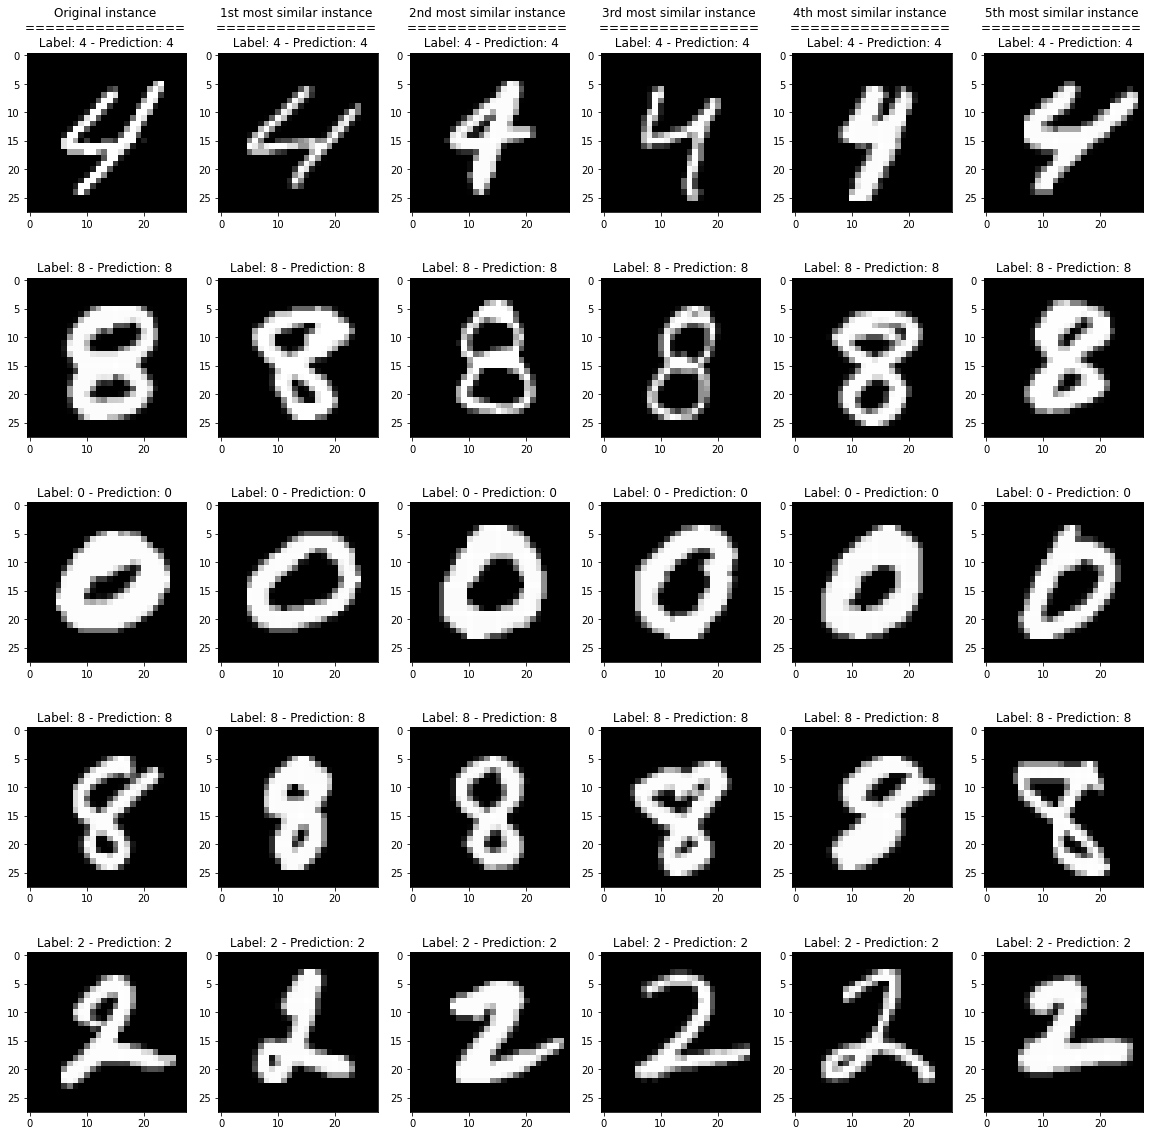

In [13]:
plot_similar(ds)

## Most similar labels distributions 

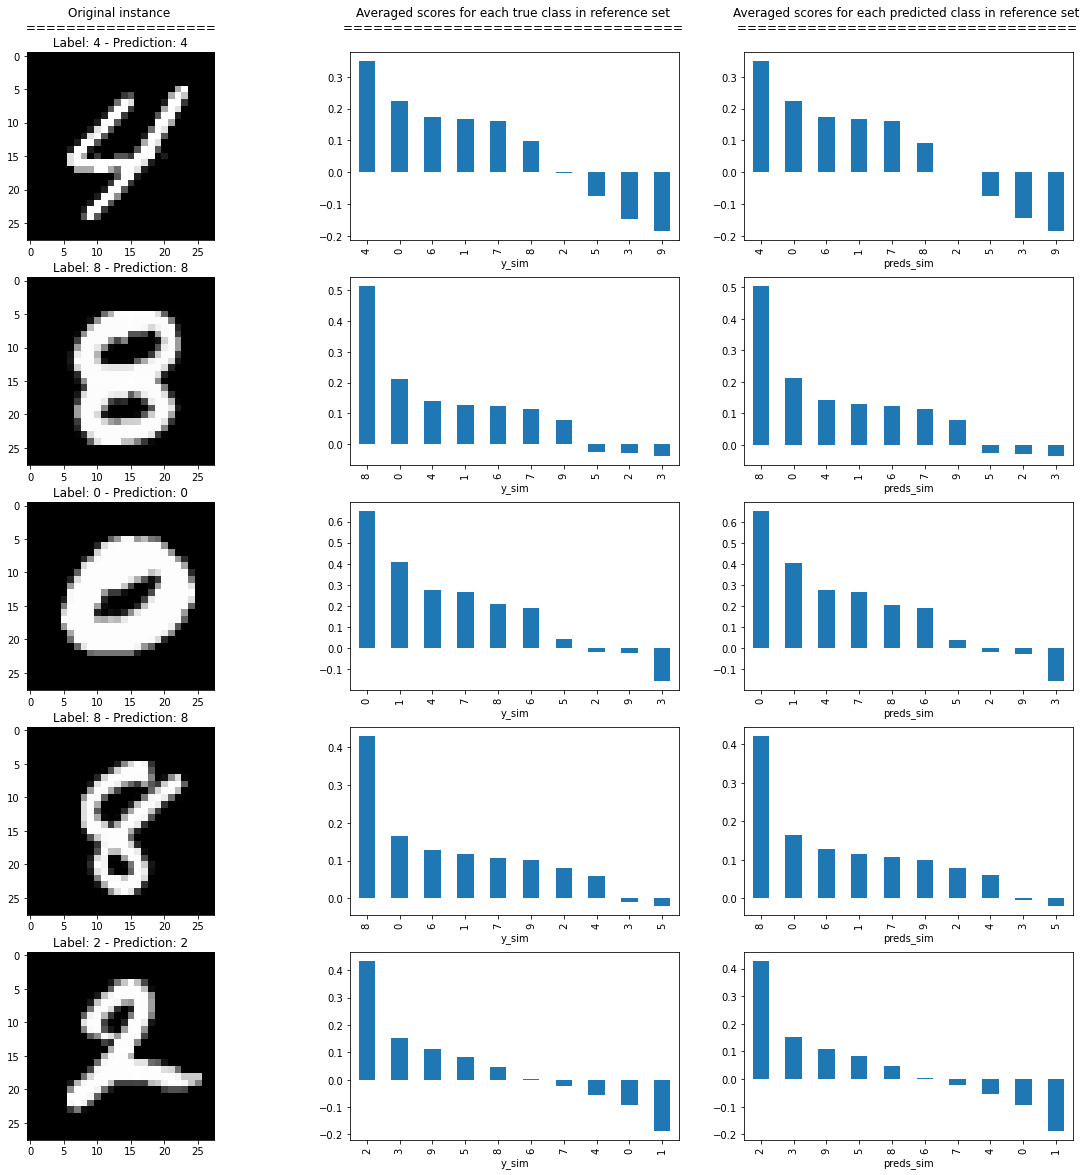

In [14]:
plot_distributions(ds)